## Importing Libraries

In [21]:
from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise import SVD
from surprise import AlgoBase
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNBaseline
from surprise.prediction_algorithms import KNNWithMeans
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.predictions import PredictionImpossible

import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

import itertools

from six import iteritems
import heapq

import timeit

## Loading Data (MovieLens class)
This class loads data as a surprise Dataset object. It also contains methods to get movie names by their Ids, get movie Ids by their names and  to get each users' rating and get each movie's rating datas.

In [13]:
class MovieLens:
    
    movieId_to_name = {}
    name_to_movieId = {}
    tag_data_file_path="Documents/auto_enc_rec/Data_Files/ml-20m/tags.csv"
    rating_data_file_path='Documents/auto_enc_rec/Data_Files/ml-20m/ratings.csv'
    tags_df = pd.DataFrame()
      
    def filterData(self, keep_number=20000):
        '''keeps movies with the max number of tag repeatitions'''
        tags_data = pd.read_csv(self.tag_data_file_path)
        
        self.tags_df = tags_data.groupby(['movieId', 'tag']).size()
        
        self.tags_df = self.tags_df.sort_values(ascending=False)
        self.tags_df = self.tags_df.head(keep_number)
        
        self.tags_df = self.tags_df.to_frame('freq')
        
        self.tags_df = self.tags_df.reset_index()
        
    
    def findFilteredUsers(self):
        '''keep users from rating_file that are similiar to users in tags_df'''
        rate_df = pd.read_csv(self.rating_data_file_path)
        
        rate_df = rate_df[['userId', 'movieId', 'rating']]
        
        mask = rate_df.movieId.isin(self.tags_df.movieId) # Filtering....
        rate_df = rate_df[mask]
        
        rate_df = rate_df.reset_index()
        
        rate_df = rate_df.drop(columns=['index']) # del old index column (we have two index columns now)
        
        return rate_df
    
    def loadData(self):
        '''loads data as a surprise obj'''
        self.rate_df = self.findFilteredUsers()
        
        # Loading data into a Surprise Dataset object
        reader = Reader(rating_scale=(0.5, 5))
        ratingsDataset = Dataset.load_from_df(self.rate_df[['userId', 'movieId', 'rating']], reader)
        
        df = pd.read_csv('movies.csv')
        
        for index, row in df.iterrows():
            self.movieId_to_name[row['movieId']] = row['title']
            self.name_to_movieId[row['title']] = row['movieId']
            
        self.user_num = self.rate_df.userId.unique().size
        self.movie_num = self.tags_df.movieId.unique().size
        self.tag_num = self.tags_df.tag.unique().size
        
        if (self.movie_num != self.rate_df.movieId.unique().size): # check to see if the same users exist in both-
            print("Number of movies don't match")             # rate_df (ratings data frame) and tags_df
            return None
        
        print("The number of movies is: " + str(self.movie_num))
        print("The number of user is: " + str(self.user_num))
        print("The number of tags is: " + str(self.tag_num))
        
        return ratingsDataset
    
    def getMovieName(self, movie_id):
        '''returns movie Name. Id should be an int'''
        if movie_id in self.movieId_to_name:
            return self.movieId_to_name[movie_id]
        else:
            return 0

    def getMovieId(self, movie_name):
        '''returns movie Id. Name should be a string'''
        if movie_name in self.name_to_movieId:
            return self.name_to_movieId[movie_name]
        else:
            return 0
        
    def getUserRatings(self, userId):
        '''return a list of tuples in the shape of (movieId, rating). UserId must be an int'''
        user_ratings = []
        
        df = self.rate_df
        
        df_filter = df[df['userId'] == userId]
        
        for index, row in df_filter.iterrows():
            movieId = int(row['movieId'])
            rating = float(row['rating'])
            user_ratings.append((movieId, rating))
            
        return user_ratings
    
    def getMovieRetings(self, movieId):
        '''return a list of tuples in the shape of (userId, rating). movieId must be an int'''
        movie_ratings = []
        
        df = self.rate_df
    
        df_filter = df[df['movieId'] == movieId]
        
        for index, row in df_filter.iterrows():
            userId = int(row['userId'])
            rating = float(row['rating'])
            movie_ratings.append((userId, rating))
            
        return movie_ratings
    
    def getMovieTags(self, movieId):
        print("return Movie tags")
        
    def getUserTags(self, userId):
        print("return User Tags")
        
    def getTfidf(self):
        '''return tf-idf matrix'''
        df = self.tags_df
        
        pivot_df = df.pivot(index='movieId', columns='tag', values='freq').fillna(0) 
        
        self.movie_index_list = pivot_df.index.tolist() # this index list is going to be used after profiles are represented 
        
        pivot_np = np.array(pivot_df)
        
        tag_sum = np.sum(pivot_np, axis=1)
        tag_sum = tag_sum.reshape(pivot_np.shape[0], 1)
        tf = pivot_np / tag_sum

        one_pivot = pivot_np
        one_pivot[pivot_np > 1] = 1
        
        doc_sum = np.sum(one_pivot, axis=0)
        doc_sum = doc_sum.reshape(1, pivot_np.shape[1])
        idf = np.log(one_pivot.shape[0] / doc_sum)
        
        tf_idf = tf * idf
        
        return tf_idf
    
    def getMovieNum(self):
        '''Returns the number of movies in the data set'''
        return self.movie_num
    
    def getUserNum(self):
        '''Returns the number of users in the data set'''
        return self.user_num
    
    def getTagNum(self):
        '''Returns the number of tags in the data set'''
        return self.tag_num

## Sparse_auto_enc Class
This class trains a sparse auto-encoder nn. Because stacked training is used to train deep autoencoders, this same class can be used for the training of deep networks with the values of first hidden layer as its inputs.

Error function is as follows:
\begin{equation*}
error = (1/2m) \sum_{i=1}^{i=m} \left \|y^{i} - \hat{y}^{i} \right \|^2 + \beta * P
\end{equation*}
\begin{equation*}
P = \sum_{j=1}^{j=n} D_{KL}(\rho || \bar{\rho})
\end{equation*}
\begin{equation*}
D_{KL}(\rho || \bar{\rho}) = \rho log(\rho / \hat{\rho_{j}}) + (1-\rho)log[(1-\rho)/(1-\hat{\rho_{j}})]
\end{equation*}
\begin{equation*}
\hat{\rho}_{j} = (1/m) * \sum_{i=1}^{i=m}a_{i}^{1}
\end{equation*}

In [3]:
class spares_auto_enc:
    
    def __init__(self, data, hidden_dim=1000, beta=3):
        '''hidden_dim is the dimmension of the hidden layer and beta is the weight of KL-Divergence'''
        self.data = data
        self.hidden_dim = hidden_dim
        self.beta = beta
        
    def makeGraph(self):
        '''Makes the network graph'''
        input_dim = np.size(self.data, 1)
        output_dim = input_dim
        
        self.X = tf.placeholder(tf.float32, shape=[None, input_dim])
        
        self.a1 = fully_connected(self.X, self.hidden_dim)
        self.a2 = fully_connected(self.a1, output_dim)
    
    def computeError(self):
        rho = 0.1
        
        self.makeGraph()
        
        # compute mean square error
        norms = tf.reduce_sum(tf.square(self.a2-self.X), axis=1)
        rmse = tf.reduce_mean(norms)
        c_rmse = 0.5 * rmse
        
        # kullback leibler divergence error
        rho_bar = tf.reduce_mean(self.a1, axis=0)
        d_kl = rho * tf.log(rho/tf.abs(rho_bar)) + (1-rho) * tf.log((1-rho) / tf.abs(1-rho_bar))
        p = tf.reduce_sum(d_kl)

        # compute training error
        self.train_error = c_rmse + self.beta*p

        # compute root mean sqaure error
        self.rmse = tf.sqrt(tf.reduce_mean(norms))
            
            
        
    def train(self, learning_rate=0.001, epochs=400, full_batch=True, batch_size=100):
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_error = self.computeError()
        train = optimizer.minimize(self.train_error)
        
        init = tf.global_variables_initializer()
        
        self.sess = tf.Session()
        
        self.sess.run(init)
        
        print("Training Started")
        
        err_list = []
        epoch_list = []
        
        for epoch in range(epochs):
        
            self.sess.run(train, feed_dict={self.X: self.data})
            error = self.sess.run(self.train_error, feed_dict={self.X: self.data})

            if epoch % 10 == 0:
                print ("\nepoch no: " + str(epoch))
                print("error value: " + str(error))

            if (error < 50):
                err_list.append(error)
                epoch_list.append(epoch)
                
            if(epoch == epochs-1):
                print("\nFinal Training Error Equals: " + str(error))
            
        print("\nTrainig Finished")
        
        plt.scatter(x=epoch_list, y=err_list ,marker='*')
        plt.plot(epoch_list, err_list)
        plt.xlabel("Epoch")
        plt.ylabel("Training Error Value")
        
    
    def encode(self, input_data):
        return self.sess.run(self.a1, feed_dict={self.X: input_data})


In [4]:
class similiarity:
    
    def __init__(self, input_mat):
        self.input_mat = input_mat
        
    def compute_sim(self):
        return cosine_similarity(self.input_mat)
    
    def build_sim_df(self, index):
        sim_mat = self.compute_sim()
        df = pd.DataFrame(data = sim_mat, index=index, columns=index)
        return df
        

## SparseAutoRecAlgorithm
This class is inherited form the Surprise AlgoBase class.

In [18]:
class SparseAutoRecAlgorithm(AlgoBase):
    
    def __init__(self, m, k=40, min_k=1):
        AlgoBase.__init__(self) # AlgoBase base class
        self.m = m
        self.test_count = 0
        self.k = k
        self.min_k = min_k
        self.test_count = 0
        
    def round_of_rating(self, rate):
        '''Estimated rating is rounded to nearest 0.5'''
        if rate <= 0.5:
            return 0.5
        elif rate >= 5:
            return 5
        else:
            return round(rate * 2) / 2
        
        
    def fit(self, trainset):
        AlgoBase.fit(self, trainset) # AlgoBase base class
 
        tf_idf = self.m.getTfidf()
        
        sp_model = spares_auto_enc(tf_idf)
        sp_model.train(epochs=100)
        encoded_data = sp_model.encode(tf_idf)
        
        sim = similiarity(encoded_data)
        self.sim_df = sim.build_sim_df(self.m.movie_index_list)
        
        self.n_x = self.trainset.n_items
        self.n_y = self.trainset.n_users
        self.xr = self.trainset.ir
        self.yr = self.trainset.ur
        
        self.means = np.zeros(self.n_x)
        for x, ratings in iteritems(self.xr):
            self.means[x] = np.mean([r for (_, r) in ratings])
        
        return self
    
    def estimate(self, iuid, iiid):
        
        x = iiid # These are internal ids 
        y = iuid # These are internal ids 
        
        self.test_count = self.test_count + 1 # count the number of teseted examples
        
        if self.test_count % 100000 == 0:
            print("\ntest_count is: " + str(self.test_count))
            
        # convert internal ids to raw ids
        iid = self.trainset.to_raw_iid(iiid)
        uid = self.trainset.to_raw_uid(iuid)
        
        if not (self.trainset.knows_user(iuid) and self.trainset.knows_item(iiid)):
            raise PredictionImpossible('User and/or item is unkown.')

        neighbors = []
        for (x2, r) in self.yr[y]:
            x2_raw_id = self.trainset.to_raw_iid(x2)
            sim = self.sim_df.at[int(iid), int(x2_raw_id)]
            neighbors.append((x2, sim , r))
                             
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[1])
        
        est = self.means[x]

        # compute weighted average
        sum_sim = sum_ratings = actual_k = 0
        for (nb, sim, r) in k_neighbors:
            if sim > 0:
                sum_sim += sim
                sum_ratings += sim * (r - self.means[nb])
                actual_k += 1

        if actual_k < self.min_k:
            sum_ratings = 0

        try:
            est += sum_ratings / sum_sim
        except ZeroDivisionError:
            pass  # return mean

      #  details = {'actual_k': actual_k}
        return est   
        

## Experiment 1: Computing the RMSE
In this experiment 20% of the whole data (nearly 15 milion user-ratings) is used as test data to compute the rmse of the proposed algorithm. This experiment takes some time to be done. The computed rmse equals 0.8622.

In [6]:
m = MovieLens()

In [7]:
m.filterData()

In [8]:
data = m.loadData()

The number of movies is: 3312
The number of user is: 138493
The number of tags is: 3898


In [11]:
trainSet, testSet = train_test_split(data, test_size=.2, random_state=1)

In [12]:
algo = SparseAutoRecAlgorithm(m)


Training Started

epoch no: 0
error value: 150.373

epoch no: 10
error value: 21.5651

epoch no: 20
error value: 7.03892

epoch no: 30
error value: 9.1895

epoch no: 40
error value: 6.3864

epoch no: 50
error value: 5.3175

epoch no: 60
error value: 5.33148

epoch no: 70
error value: 5.17112

epoch no: 80
error value: 5.12013

epoch no: 90
error value: 5.11186

Final Training Error Equals: 5.10044

Trainig Finished


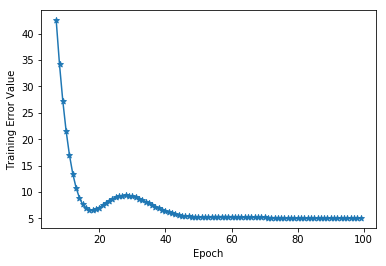

In [13]:
algo.fit(trainSet)


In [14]:
predictions = algo.test(testSet)


test_count is: 100000

test_count is: 200000

test_count is: 300000

test_count is: 400000

test_count is: 500000

test_count is: 600000

test_count is: 700000

test_count is: 800000

test_count is: 900000

test_count is: 1000000

test_count is: 1100000

test_count is: 1200000

test_count is: 1300000

test_count is: 1400000

test_count is: 1500000

test_count is: 1600000

test_count is: 1700000

test_count is: 1800000

test_count is: 1900000

test_count is: 2000000

test_count is: 2100000

test_count is: 2200000

test_count is: 2300000

test_count is: 2400000

test_count is: 2500000

test_count is: 2600000

test_count is: 2700000

test_count is: 2800000

test_count is: 2900000

test_count is: 3000000

test_count is: 3100000


In [15]:
rmse = accuracy.rmse(predictions, verbose=True)

RMSE: 0.8622


## Experiment2: Comparision with some benchmark algorithms
you can find a comparison between rmse and ame of benchmark algorithms at http://surpriselib.com/. To reduce the time needed for computation 20000 user-ratings have been selected for the test data.

In [90]:
result_list = []

In [14]:
m1 = MovieLens()

In [15]:
m1.filterData()

In [16]:
data = m1.loadData()

The number of movies is: 3312
The number of user is: 138493
The number of tags is: 3898


In [17]:
trainSet, testSet = train_test_split(data, test_size=20000, random_state=1)

### Tag Similiarity Based Sparse Auto-encoder Recommender System

Training Started

epoch no: 0
error value: 151.281

epoch no: 10
error value: 21.8418

epoch no: 20
error value: 6.95526

epoch no: 30
error value: 9.09155

epoch no: 40
error value: 6.28157

epoch no: 50
error value: 5.17897

epoch no: 60
error value: 5.17816

epoch no: 70
error value: 5.01184

epoch no: 80
error value: 4.95527

epoch no: 90
error value: 4.94441

Final Training Error Equals: 4.93166

Trainig Finished


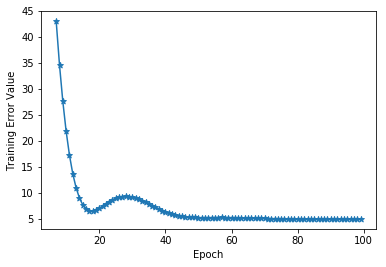

In [22]:
start_time = timeit.default_timer()
sparse_auto_enc_algo = SparseAutoRecAlgorithm(m1)
predictions_sparse_auto_enc = sparse_auto_enc_algo.fit(trainSet).test(testSet)
auto_enc_elapsed = timeit.default_timer() - start_time

In [24]:
auto_enc_rmse = accuracy.rmse(predictions_sparse_auto_enc, verbose=True)
auto_enc_mae = accuracy.mae(predictions_sparse_auto_enc, verbose=True)

RMSE: 0.8558
MAE:  0.6584


In [91]:
result_list.append([auto_enc_rmse, auto_enc_mae, auto_enc_elapsed])

### Item-based KNN Collaborative Filtering

In [26]:
ItemKNN = KNNWithMeans(sim_options = {'name': 'cosine', 'user_based': False})

In [27]:
start_time = timeit.default_timer()
predictions_item_knn = ItemKNN.fit(trainSet).test(testSet)
item_knn_elapsed = timeit.default_timer() - start_time

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [29]:
item_knn_rmse = accuracy.rmse(predictions_item_knn, verbose=True)
item_knn_mae = accuracy.mae(predictions_item_knn, verbose=True)

RMSE: 0.8080
MAE:  0.6170


In [92]:
result_list.append([item_knn_rmse, item_knn_mae, item_knn_elapsed])

### SVD

In [32]:
svd_algo = SVD()

In [33]:
start_time = timeit.default_timer()
predictions_svd = svd_algo.fit(trainSet).test(testSet)
svd_elapsed = timeit.default_timer() - start_time

In [34]:
svd_rmse = accuracy.rmse(predictions_svd, verbose=True)
svd_mae = accuracy.mae(predictions_svd, verbose=True)

RMSE: 0.7655
MAE:  0.5819


In [93]:
result_list.append([svd_rmse, svd_mae, svd_elapsed])

### Co Clustering

In [39]:
co_clust_alg = CoClustering()

In [41]:
start_time = timeit.default_timer()
predictions_clust = co_clust_alg.fit(trainSet).test(testSet)
clust_elapsed = timeit.default_timer() - start_time

In [42]:
clust_rmse = accuracy.rmse(predictions_clust, verbose=True)
clust_mae = accuracy.mae(predictions_clust, verbose=True)

RMSE: 0.8636
MAE:  0.6775


In [94]:
result_list.append([clust_rmse, clust_mae, clust_elapsed])

### Random

In [45]:
rand_alg = NormalPredictor()
start_time = timeit.default_timer()
predictions_rand = rand_alg.fit(trainSet).test(testSet)
rand_elapsed = timeit.default_timer() - start_time

In [65]:
rand_rmse = accuracy.rmse(predictions_rand, verbose=True)
rand_mae = accuracy.mae(predictions_rand, verbose=True)

RMSE: 1.3894
MAE:  1.1055


In [95]:
result_list.append([rand_rmse, rand_mse, rand_elapsed])
result_list = [[round(rmse, 3), round(mse, 3), round(time)] for rmse, mse, time in result_list ]

### Experiment results for rating prediction of 20000 (user, item) pairs with different algorithms are as follows:

In [122]:
resuls_df = pd.DataFrame(data=result_list, index=['Tag Based Sparce Auto-encoder', 'Item based CF KNN with Means', 'Singular Value Decomposition', 'Co-Clustering', 'Random Recommendation'], columns=['RMSE', 'MSE', 'Run Time in Seconds'])
resuls_df

,RMSE,MSE,Run Time in Seconds
Tag Based Sparce Auto-encoder,0.856,0.658,369
Item based CF KNN with Means,0.808,0.617,1179
Singular Value Decomposition,0.765,0.582,999
Co-Clustering,0.864,0.678,571
Random Recommendation,1.389,1.106,14


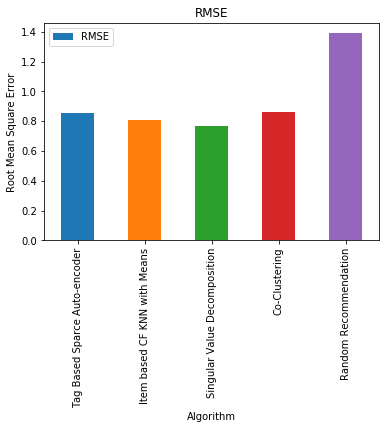

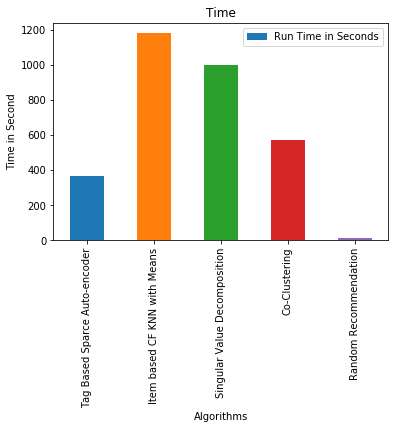

In [126]:
new_df = resuls_df.reset_index()
rmse_plot = new_df.plot(x = 'index', y = 'RMSE', kind='bar', title='RMSE')
rmse_plot.set_xlabel('Algorithm')
rmse_plot.set_ylabel('Root Mean Square Error')
time_plot = new_df.plot(x = 'index', y = 'Run Time in Seconds', kind='bar', title='Time')
time_plot.set_xlabel('Algorithms')
time_plot.set_ylabel('Time in Second')

### Discussion:
As you can see above the proposed algorithm outperforms all other algorithms in the run-time and also yields a RMSE error better than Co-Clustering and very close to item-based CF with Means. It seems like tf-idf has been an appropriate feature to compute the similarity between items and sparse auto encoder has done a great job in making a good representation of these features. Also because the dimension of the extracted features space is less than the dimension of the items space (nearly one third), therefore making and searching of the similarity matrix takes much less time and this has a very significant impact on the speed of fitting to train data and estimation of the rating for the test data.